/opt/miniconda3/envs/poza-fria/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/miniconda3/envs/poza-fria/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/miniconda3/envs/poza-fria/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


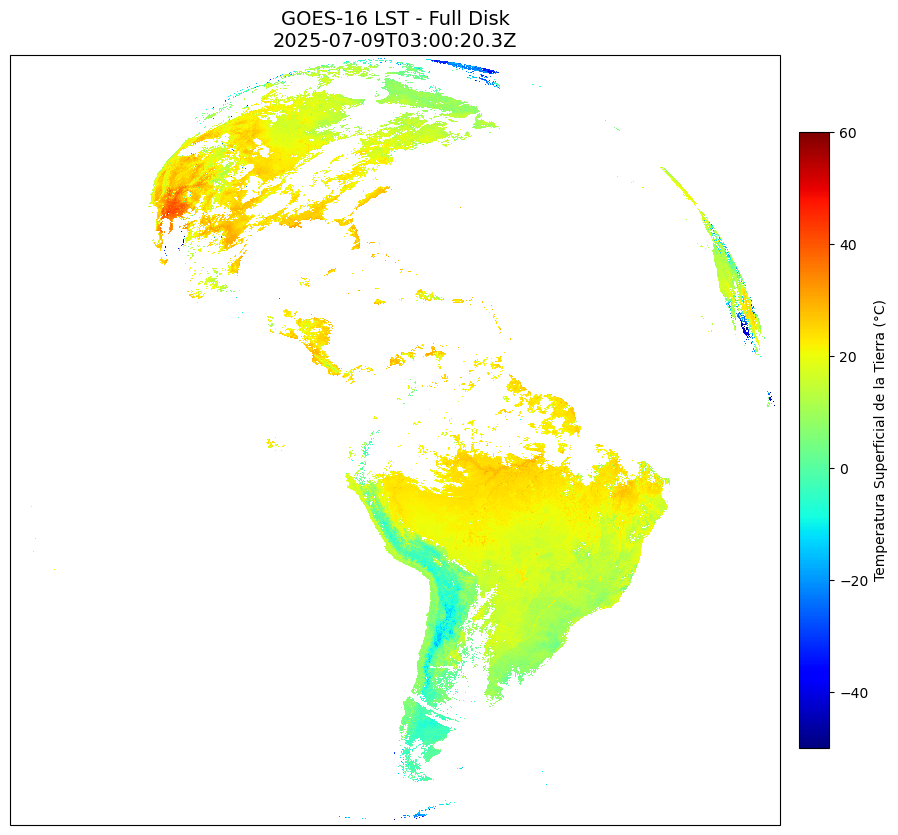

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# 1. Cargar el dataset (usamos open_dataset para ver todas las variables correctamente)
# Reemplaza 'tu_archivo.nc' con la ruta real de tu archivo
fn = '/Users/pibonacic/Documents/GitHub/poza-fria/data/ABI-L2-LST2KMF-2025-190-03-OR_ABI-L2-LST2KMF-M6_G19_s20251900300203_e20251900309511_c20251900314525.nc'
ds = xr.open_dataset(fn)

# 2. Analizar la proyección del satélite GOES
# Los atributos necesarios están dentro de la variable "goes_imager_projection"
proj_info = ds['goes_imager_projection'].attrs

# Definimos el sistema de referencia de coordenadas (CRS) usando Cartopy
geostationary_crs = ccrs.Geostationary(
    central_longitude=proj_info['longitude_of_projection_origin'],
    satellite_height=proj_info['perspective_point_height'],
    sweep_axis=proj_info['sweep_angle_axis']
)

# 3. Preparar los datos de LST (Land Surface Temperature)
# Xarray aplica automáticamente la escala y el offset definidos en los atributos
data = ds['LST']

# Opcional: Convertir de Kelvin a Celsius para facilitar la lectura
data_celsius = data - 273.15

# Opcional: Enmascarar datos de baja calidad usando DQF si es necesario
# (Aquí visualizamos todo lo válido, los valores nulos ya vienen como NaN)

# 4. Generar la Visualización
fig = plt.figure(figsize=(12, 10))

# Crear un eje con la proyección geoestacionaria
ax = fig.add_subplot(1, 1, 1, projection=geostationary_crs)

# Dibujar las costas y fronteras para referencia geográfica
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray')

# Graficar la temperatura
# x e y son las coordenadas en radianes del archivo original
im = ax.pcolormesh(
    ds['x'], ds['y'], data_celsius,
    transform=geostationary_crs, # Importante: dice que los datos están en esta proyección
    cmap='jet', # Mapa de color (puedes usar 'inferno', 'plasma', 'coolwarm')
    vmin=-50, vmax=60 # Rango de temperatura visual (ajustar según necesidad)
)

# Añadir barra de color
cbar = plt.colorbar(im, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('Temperatura Superficial de la Tierra (°C)')

# Título y visualización
plt.title(f"GOES-16 LST - Full Disk\n{ds.time_coverage_start}", fontsize=14)
plt.show()

# Cerrar el dataset al terminar
ds.close()

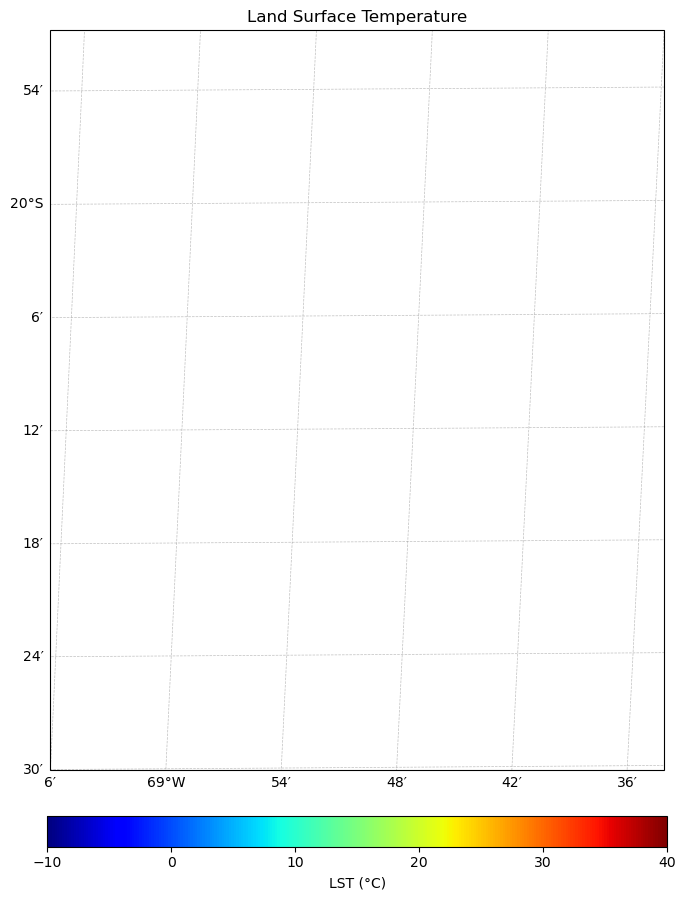

In [6]:
# 1. DEFINIR LA EXTENSIÓN (Bounding Box)
# Basado en los ejes de tu imagen:
# [Longitud Oeste, Longitud Este, Latitud Sur, Latitud Norte]
extent_img = [-69.1, -68.6, -20.5, -19.85] 

fig = plt.figure(figsize=(10, 12))

# Usamos la proyección geoestacionaria definida anteriormente
ax = fig.add_subplot(1, 1, 1, projection=geostationary_crs)

# 2. APLICAR EL ZOOM A LA ZONA ESPECÍFICA
# Es CRUCIAL pasar crs=ccrs.PlateCarree() para que entienda que son grados lat/lon
ax.set_extent(extent_img, crs=ccrs.PlateCarree())

# Dibujar características geográficas (importante para ubicarse en el zoom)
# Usamos una resolución más alta ('10m') para que se vean bien las fronteras al hacer zoom
#ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black') 
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')

# 3. GRAFICAR LOS DATOS
# Nota: Usamos 'copper' o 'inferno' para imitar los tonos tierra/calor de tu imagen
im = ax.pcolormesh(
    ds['x'], ds['y'], data_celsius,
    transform=geostationary_crs,
    cmap='jet',  # Mapa de color 
    vmin=-10, vmax=40 # Ajusta esto según la temperatura real de la zona en ese momento
)

# Añadir grilla de coordenadas (Lat/Lon) para verificar
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.colorbar(im, label='LST (°C)', orientation='horizontal', pad=0.05, shrink=0.8)
plt.title("Land Surface Temperature")

plt.show()

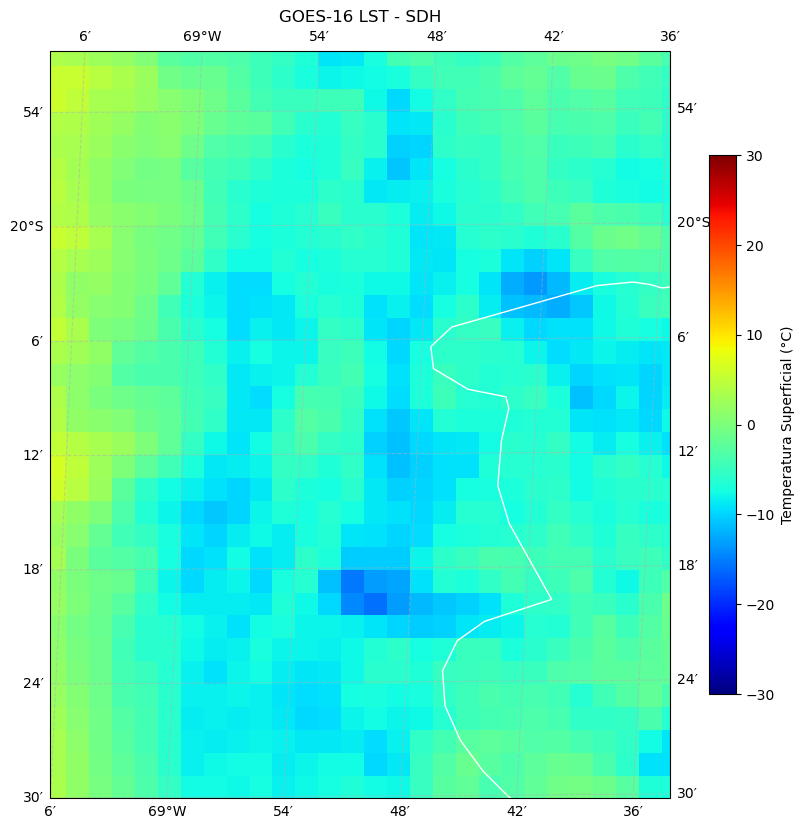

In [11]:

dat = ds.metpy.parse_cf('LST') if hasattr(ds, 'metpy') else ds['LST']

# 2. Obtener la altura del satélite para la corrección de coordenadas
# Esta es la parte CRÍTICA que faltaba
h = ds['goes_imager_projection'].attrs['perspective_point_height']

# Convertir coordenadas de radianes a metros
x_img = ds['x'] * h
y_img = ds['y'] * h

# 3. Definir la proyección Geoestacionaria
# Usamos los parámetros estándar de GOES-16
geo_crs = ccrs.Geostationary(
    central_longitude=-75.0,
    satellite_height=h,
    sweep_axis='x'
)

# 4. Configurar la visualización
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=geo_crs)

# Definir la extensión (Extent) basada en tu imagen anterior
# [Lon Oeste, Lon Este, Lat Sur, Lat Norte]
extent = [-69.1, -68.6, -20.5, -19.85]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# 5. Graficar
# IMPORTANTE: Pasamos x_img y y_img (en metros)
# Usamos 'vmin' y 'vmax' fijos para asegurar contraste. 
# Si la zona está muy fría o caliente, ajusta estos valores.
data_celsius = ds['LST'] - 273.15

im = ax.pcolormesh(
    x_img, y_img, data_celsius,
    transform=geo_crs,
    cmap='jet', # 'inferno' o 'jet' tienen buen contraste para LST
    vmin=-30, vmax=30 
)

# Agregar bordes para referencia
ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='white')
ax.coastlines(resolution='10m', color='white', linewidth=1)

# Barra de color y grilla
plt.colorbar(im, label='Temperatura Superficial (°C)', shrink=0.7)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, 
             linestyle='--', alpha=0.5)

plt.title("GOES-16 LST - SDH")
plt.show()